In [1]:
DATASETS = ["adult", "ionosphere", "liver", "transfusion", "wdbc"]
MODELS = ["imli", "imli-quantile"]
ATTRIBUTES = [' train_accuracy']
ZOOM_ID = 0

In [2]:
import numpy as np
import pandas as pd

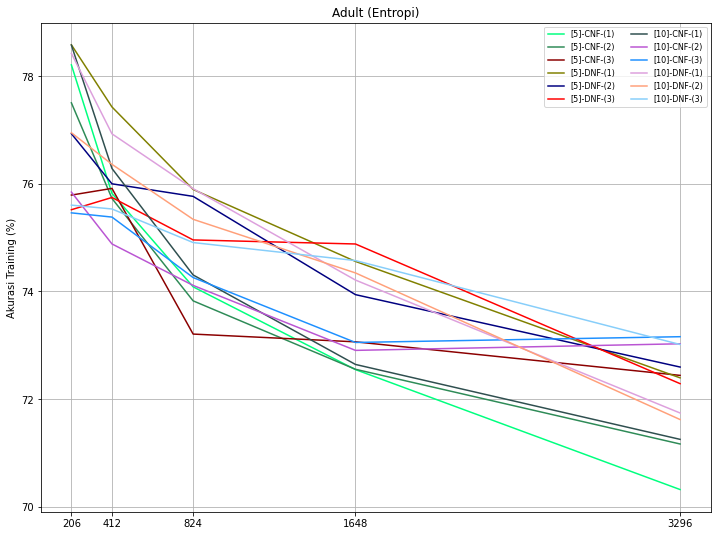

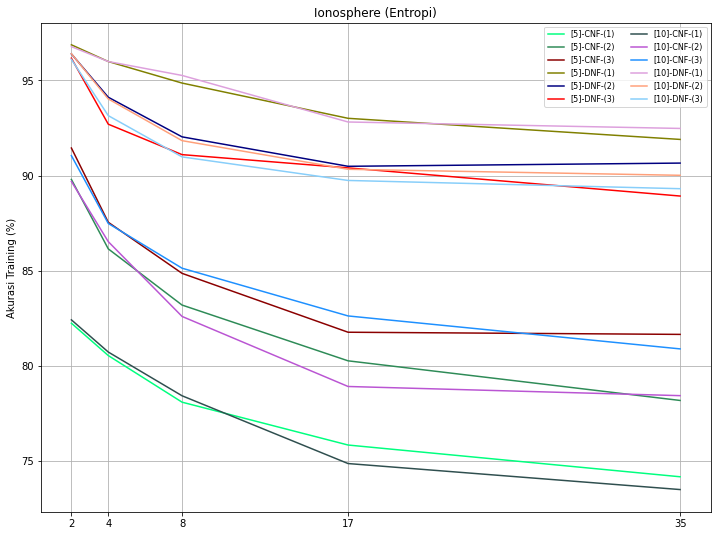

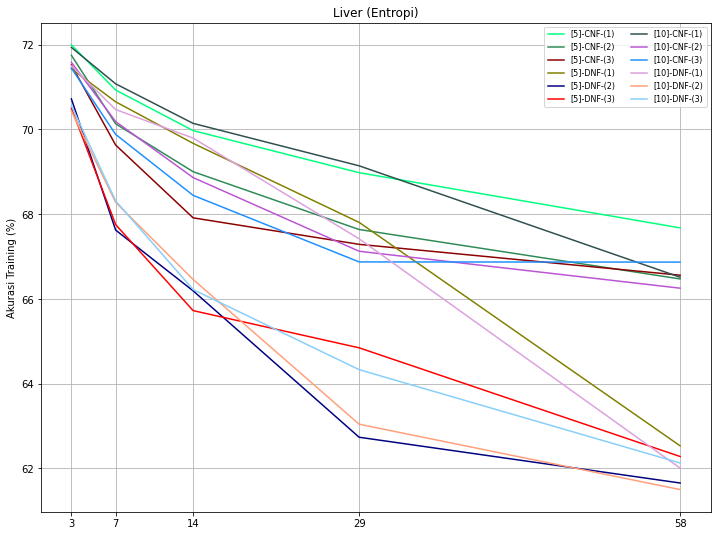

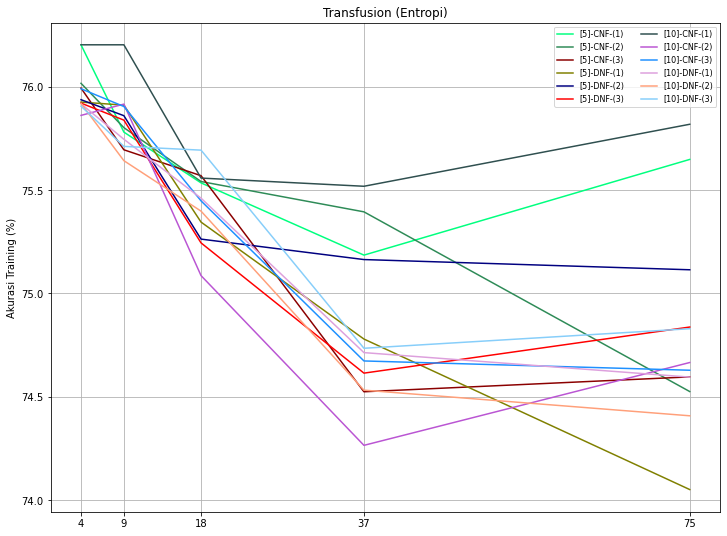

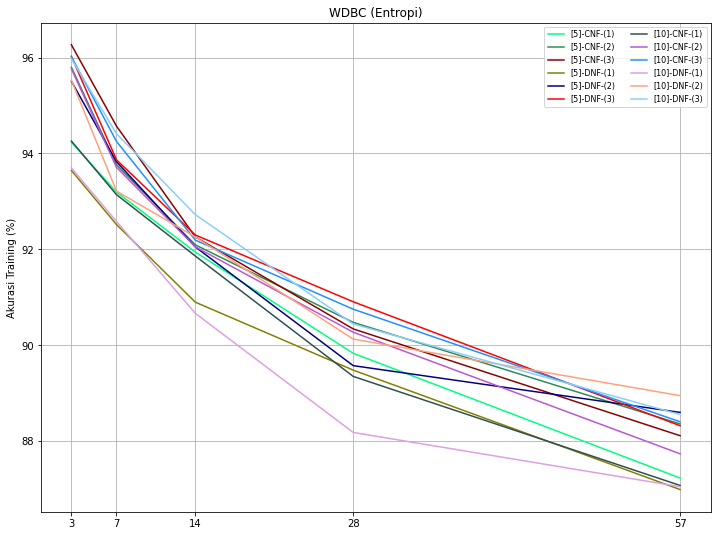

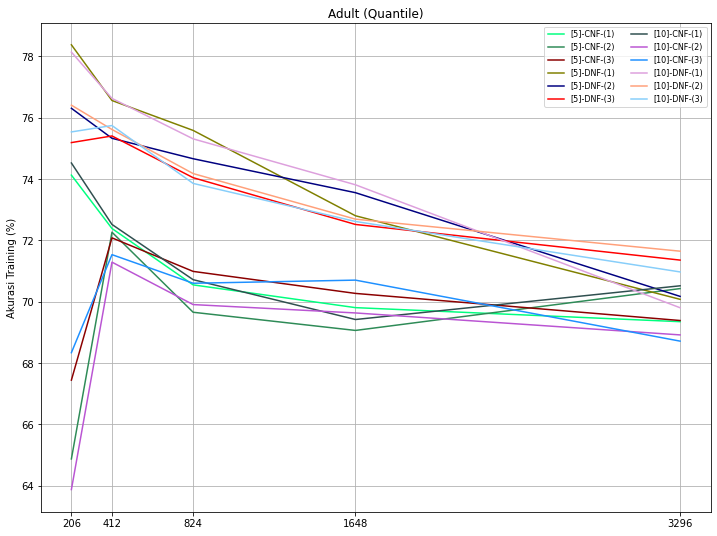

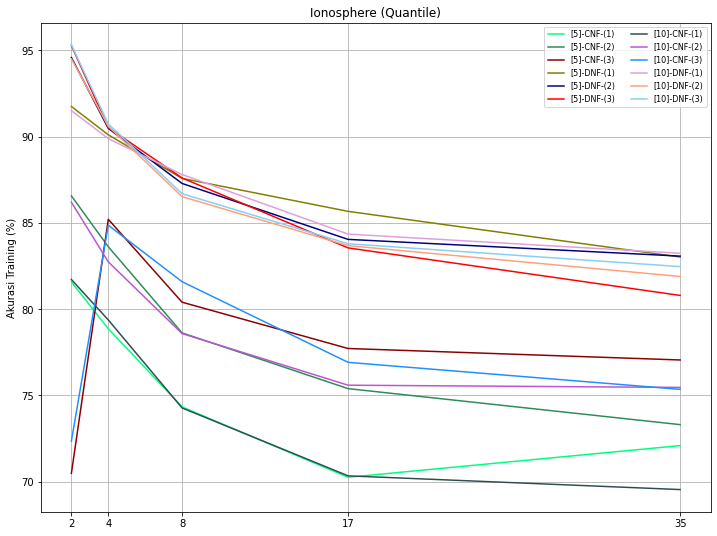

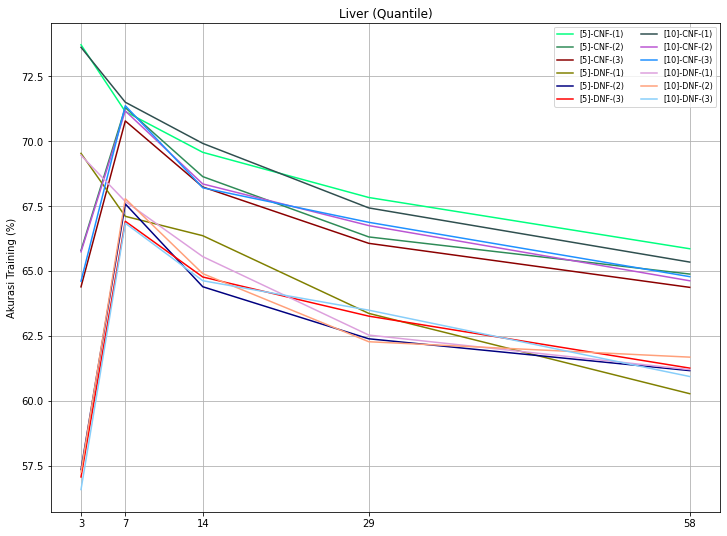

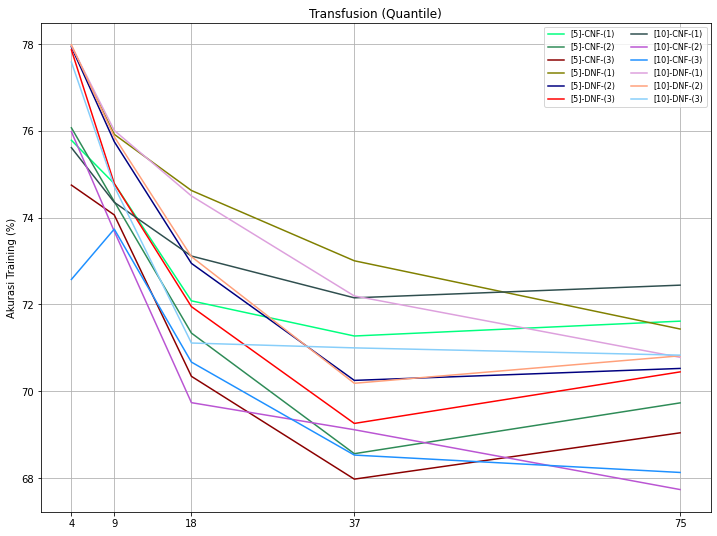

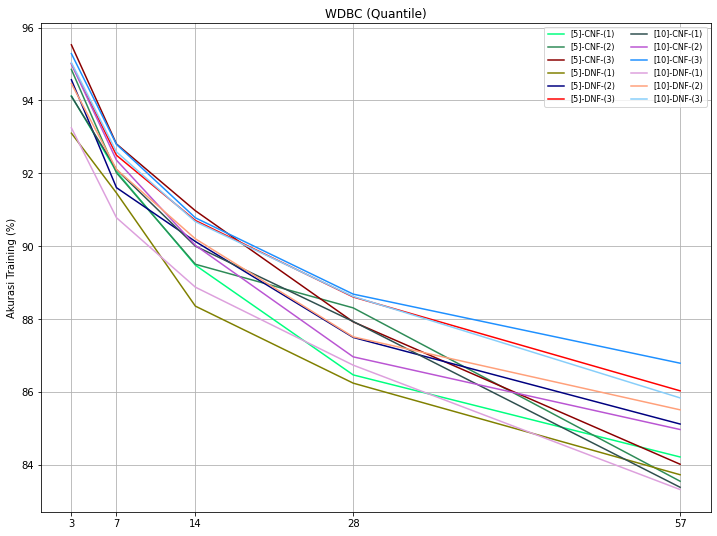

In [3]:
map_dataset = {
    "adult" : "Adult",
    "ionosphere": "Ionosphere",
    "liver": "Liver",
    "transfusion": "Transfusion",
    "wdbc": "WDBC"
}

map_model = {
    "imli": "Entropi",
    "imli-quantile": "Quantile"
}

map_attr = {
    ' training_time': "Waktu Training (detik)",
    ' rule_size': "Ukuran Rule",
    ' val_accuracy': "Akurasi Validasi (%)",
    ' train_accuracy': "Akurasi Training (%)"
}

for ATTRIBUTE in ATTRIBUTES:
    for MODEL in MODELS:
        for DATASET in DATASETS:
            working_dir = "./" + DATASET + "/{}/".format(MODEL)
            df = pd.read_csv(working_dir + "log-{}-0.csv".format(MODEL))
            df['holdout_id'] = 0

            for i in range(1, 10):
                tmp = pd.read_csv(working_dir + "log-{}-%d.csv".format(MODEL) % i)
                tmp['holdout_id'] = i
                df = df.append(tmp)
                
            def extract_accuracy(clf):
                clf_comma = clf.replace(';', ',')
                clf_obj = eval(clf_comma)
                return clf_obj['accuracy']

            df[' train_accuracy'] = df[' classification_report_train'].apply(extract_accuracy)
            grouped = df.groupby(['lamda', ' n_clause', ' rule_type', ' n_partitions'])[ATTRIBUTE].mean()
            
            n_partitions = grouped[5][1]["CNF"].keys()
            %matplotlib inline
            
            import matplotlib.pyplot as plt
            fig = plt.figure(figsize=(12, 9))

            plt.title("{} ({})".format(map_dataset[DATASET], map_model[MODEL]))
            plt.ylabel(map_attr[ATTRIBUTE])
            plt.xticks(n_partitions)

            colors = [
                "#00ff7f",
                "#2e8b57",
                "#8b0000",
                "#808000",
                "#000080",
                "#ff0000",
                "#2f4f4f",
                "#ba55d3",
                "#1e90ff",
                "#dda0dd",
                "#ffa07a",
                "#87cefa"
            ]

            id_c = 0
            for lamda in [5, 10]:
                for rule_type in ['CNF', 'DNF']:
                    for n_clause in [1, 2, 3]:
                        d = dict(grouped[lamda][n_clause][rule_type])
                        plt.plot(
                            list(d.keys())[ZOOM_ID:],
                            list(d.values())[ZOOM_ID:] if ATTRIBUTE != ' val_accuracy' and ATTRIBUTE != ' train_accuracy'  else [u * 100 for u in list(d.values())],
                            label="[{}]-{}-({})".format(lamda,rule_type, n_clause),
                            color=colors[id_c]
                        )
                        id_c += 1
            plt.grid(axis='both')
            plt.legend(ncol=2, prop={'size': 8})
            plt.savefig("./_plot/" + ATTRIBUTE.strip() + "/" + DATASET + "-" + map_model[MODEL].lower() + ".jpg", bbox_inches = 'tight')
            plt.show()